In [ ]:
import numpy as np
import pandas as pd                                         #importing libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dense,Flatten,Reshape,LeakyReLU,Dropout,Input,Concatenate,Embedding

In [ ]:
def load_dataset():
 (images,labels),(_,_)= datasets.mnist.load_data()
 images=images.reshape(images.shape[0],28,28,1)                                  # function to load mnist dataset
 images=images.astype('float32')
 images=(images-127.5)/127.5
 dataset=(images,labels)
 return dataset

In [ ]:
def define_discriminator(latent_dim=100):
  in_label=Input(shape=(1,))
  li=Embedding(10,50)(in_label)
  li=Dense(28*28)(li)
  li=Reshape((28,28,1))(li)
  in_image=Input(shape=(28,28,1))                                                  # function to define discriminator
  li=Concatenate()([in_image,li])
  li=Conv2D(64,(3,3),strides=(2,2),padding='same')(li)
  li=LeakyReLU()(li)
  li=Conv2D(32,(3,3),strides=(2,2),padding='same')(li)
  li=LeakyReLU()(li)
  li=Flatten()(li)
  li=Dropout(0.4)(li)
  out_layer=Dense(1,activation='sigmoid')(li)
  model=Model([in_image,in_label],out_layer)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
def define_generator(latent_dim=100):
  in_label=Input(shape=(1,))                                                    # Input layer for the label
  li=Embedding(10,50)(in_label)                                                 # Embedding layer to map label to a dense vector of size 50
  li=Dense(7*7)(li)                                                             # Dense layer to transform the label embedding to a 7x7 feature map
  li=Reshape((7,7,1))(li)
  in_image=Input(shape=(100,))                                                  # Input layer for the latent vector
  gen=Dense(7*7*128)(in_image)
  gen=Reshape((7,7,128))(gen)                                                   # Reshape the feature map to a 3D tensor for convolutional layers
  li=Concatenate()([gen,li])                                                    # Concatenate the label embedding and latent representation
  li=Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(li)
  li=LeakyReLU()(li)
  li=Conv2DTranspose(16,(3,3),strides=(2,2),padding='same')(li)
  li=LeakyReLU()(li)
  out_layer=Conv2DTranspose(1,(3,3),padding='same',activation='tanh')(li)
  model=Model([in_image,in_label],out_layer)
  return model

In [ ]:
def define_gans(generator,discriminator):
  discriminator.trainable=False                                                 #training of discriminator is False because it is already trained while calling define_discriminator function
  gen_noise,gen_label=generator.input                                           #giving noise and label to generator and producing fake images
  gen_output=generator.output                                                   # giving the fake images to discriminator and returning the output as gan output

  gan_output=discriminator([gen_output,gen_label])
  model=Model([gen_noise,gen_label],gan_output)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
def generate_real_samples(dataset,n_samples):                         # function to create and return real samples(from train dataset)
  images,labels=dataset
  idx=np.random.randint(0,images.shape[0],n_samples)
  X=images[idx]
  L=labels[idx]
  Y=np.ones((n_samples,1))
  return X,L,Y

In [ ]:
def generate_latent_points(n_samples,latent_dim):                          # function to generate latent vector(noise)
  x=np.random.randn(n_samples,latent_dim)
  y=np.random.randint(0,10,n_samples)
  return x,y

In [ ]:
def generate_fake_samples(n_samples,latent_dim):                     # function to create and return fake samples(from generator)
  x,y=generate_latent_points(n_samples,latent_dim)                   # giving latent vector(noise) to generator and returning fake images
  X=generator.predict([x,y])
  L=y
  Y=np.zeros((n_samples,1))
  return X,L,Y

In [ ]:
def train(batch_size,epochs,dataset,generator,discriminator,gan):               # function to train the model
  half_batch=int(batch_size/2)
  n_batches=int(60000//batch_size)
  for i in range(epochs):
    for j in range(n_batches):
      x_real,l_real,y_real=generate_real_samples(dataset,half_batch)            # generating half batch of fake samples
      d_loss_real=discriminator.train_on_batch([x_real,l_real],y_real)          # training discriminator on real samples

      x_fake,l_fake,y_fake=generate_fake_samples(half_batch,latent_dim)         # generating half batch of fake samples
      d_loss_fake=discriminator.train_on_batch([x_fake,l_fake],y_fake)          # training discriminator on fake samples

      z_input,l_input=generate_latent_points(batch_size,latent_dim)             #generating latent points
      y_gan=np.ones((batch_size,1))                                             #giving the fake images label of 1 to confuse the discriminator and calculating the loss and updating the weights
      g_loss=gan.train_on_batch([z_input,l_input],y_gan)

      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %(i+1,j+1,n_batches,d_loss_real[0],d_loss_fake[0],g_loss[0]))
  generator.save('mnist_conditional_generator_25epochs.h5')

In [ ]:
latent_dim=100
epochs=10
batch_size=64
discriminator=define_discriminator(latent_dim)
generator=define_generator(latent_dim)
gan=define_gans(generator,discriminator)
dataset=load_dataset()
train(batch_size,epochs,dataset,generator,discriminator,gan)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
>8, 312/937, d1=0.189, d2=0.348, g=2.498
1/1 [==============================] - 0s 17ms/step
>8, 313/937, d1=0.316, d2=0.265, g=2.352
1/1 [==============================] - 0s 17ms/step
>8, 314/937, d1=0.517, d2=0.287, g=2.413
1/1 [==============================] - 0s 18ms/step
>8, 315/937, d1=0.420, d2=0.370, g=2.361
1/1 [==============================] - 0s 18ms/step
>8, 316/937, d1=0.393, d2=0.291, g=2.517
1/1 [==============================] - 0s 18ms/step
>8, 317/937, d1=0.245, d2=0.269, g=2.392
1/1 [==============================] - 0s 18ms/step
>8, 318/937, d1=0.162, d2=0.447, g=2.477
1/1 [==============================] - 0s 18ms/step
>8, 319/937, d1=0.376, d2=0.303, g=2.666
1/1 [==============================] - 0s 20ms/step
>8, 320/937, d1=0.360, d2=0.281, g=2.659
1/1 [==============================] - 0s 19ms/step
>8, 321/937, d1=0.876, d2=0.296, g=1.995
1/1 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>10, 937/937, d1=0.308, d2=0.554, g=2.122


4/4 [==============================] - 0s 27ms/step


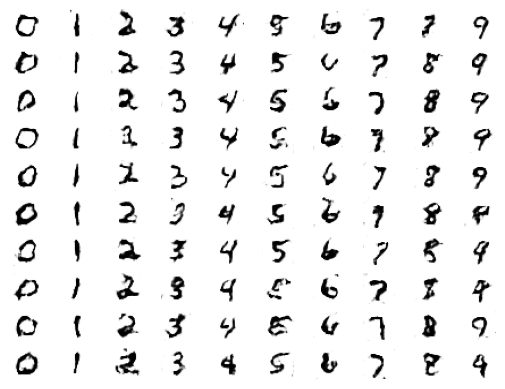

In [ ]:
from keras.models import load_model                                         #plotting the results
model=load_model('mnist_conditional_generator_25epochs.h5')

latent_points,labels=generate_latent_points(100,latent_dim)
labels= np.asarray([x for _ in range(10) for x in range(10)])
X=model.predict([latent_points,labels])
X=(X+1)/2.0
X=(X*255).astype(np.uint8)
def show_plot(examples,n):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

show_plot(X,10)